# 本ドキュメントについて

このドキュメントは、検証履歴の保存と整理を目的としています。

## 本研究のテーマ

レコメンデーションへディープラーニングを応用する方法を検証します。

## 先行研究

2016年以降、いくつかの研究がディープラーニングを使ったレコメンデーションアルゴリズムについて言及しています。

特に研究が盛んなのは、クリック率予測問題の領域で、FNNやWide&Deepなどの手法が提案されています。

これらの先行手法では、Criteoが提供するWeb広告のクリック履歴データを用いて検証しており、(ユーザー, アイテム, 満足度スコア)の組み合わせ構造をもつ、アイテムレコメンデーションのデータでの検証はそれほどありません。

## 本研究の意義

これらの先行研究を参考にしつつ、アイテムレコメンデーションでのディープラーニングの応用を検証を行います。

この場合、なぜディープラーニングなのかについて整理を行います。

1. 既存の(ユーザー, アイテム)を、例えば(ユーザー, アイテム, 時間)のより高次元な組み合わせを扱えるようになります。
2. 転移学習により、学習済みの中間重みを別のレコメンデーションシステムに適応可能になり、総体としての改善が見込まれます。（中川さんのアイデア）
3. 

(1) については、特に「時間」を加味することは非常に有効であることが他の研究でもすでに指摘されており、多次元の組み合わせでレコメンデーションを行う有効性はすでに知られています。
また、2010年に提案された Factorization Machine(FM) は、理論的には多次元の組み合わせのレコメンデーションを計算できます。

一方で、高次元な組み合わせが疎データ問題をより悪化させ、性能に影響を与えることが懸念されています。
この問題の解決をディープラーニングで実現できるかが、本研究の要点の一つとなります。

(2)については、本来は研究を分けて行うべきだと思いますが、簡単に言及しておきます。
ディープラーニングでは、学習済みのweightを別の学習セットに転用する転移学習が盛んで、これが多くの分野で性能を発揮しています。
レコメンデーションはそのアプリケーションの特異性が強く、学習やモデルを調整する必要がありますが、転移学習を用いればそれを緩和できます。
画像判別や文章解析で実績の多い転移学習が、レコメンデーションでも有効なのかを検証するのも必要な研究でしょう。


## 以降から、

プログラムコードで、検証の過程を保存、整理していきます。


In [1]:
# 学習中にWarningが発生するのでメッセージをオフにします。
import warnings
warnings.filterwarnings("ignore")


#######################
# 1. load data from src/modules/inputs.py
'''
ここで読み込んだデータは、MovieLensのショートデータです。
'''

import os
import pandas as pd
csv_fp = 'data/ml-latest-small/ratings.csv'
data = pd.read_csv(csv_fp)
column_names = ['userId', 'movieId', 'timestamp']
label_name = 'rating'

X, y = data[column_names].values, data[label_name].values

#　テストコーディング用
# X, y = X[:1000], y[:1000]


In [ ]:
# X は [user, item, timestamp] です。
X

In [ ]:
# y は　　rating です。
y

In [ ]:
########################
# 2. define same interface of recommendater models
'''
ここでは、検証する手法のgrid-searchによるパラメータチューニングを行います。
用いるvalidation セットは、上述で読み込んだ X,y です。
train, test セットは別のデータを用いるとし、このデータでgrid-searchを行います。
'''
# 自作のgrid_search　モジュールを読み込みます。
from src.grid_search import grid_search


In [ ]:
#  BaseLine である MatrixFactorization　のパラメータチューニング


from surprise import SVD  
from src.surprise_algo_wrapper import surprise_algo_wrapper # I/F統一用のラッパー

model_module = SVD
wrapper = surprise_algo_wrapper

params = [
        {'n_factors':4,   'reg_all':0.010},
        {'n_factors':8,   'reg_all':0.010}, # the BEST
        {'n_factors':16,   'reg_all':0.010},
        {'n_factors':8,   'reg_all':0.001}, 
        {'n_factors':8,   'reg_all':0.100}, 
        ]
models = [wrapper(model_module(**param)) for param in params]
best_indice, scores, each_scores = grid_search(X, y, models)    
print('scores={}'.format(scores))
print('best_param={}'.format(params[best_indice]))
print('each_scores={}'.format(each_scores))



In [ ]:
#  BaseLine である factorization machine　のパラメータチューニング
from pyfm.pylibfm import FM # factorization machine
from src.pyfm_model_wrapper import pyfm_model_wrapper # I/F統一用のラッパー

model_module = FM
wrapper = pyfm_model_wrapper

'''
    num_factors : int # 大きすぎると、python kernelが原因不明のシャットダウンを起こす？
        The dimensionality of the factorized 2-way interactions
    num_iter : int
        Number of iterations
    init_stdev : double, optional
        Standard deviation for initialization of 2-way factors.
        Defaults to 0.01.
    validation_size : double, optional # ここを0にしているとシャットダウンしやすい？
        Proportion of the training set to use for validation.
        Defaults to 0.01.
    task : string
        regression: Labels are real values.
        classification: Labels are either positive or negative.
    seed : int
        The seed of the pseudo random number generator
    reg_0 : float [注：自分でライブラリを改造して追加] 
        The regularization parameter of w0
    reg_w : float [注：自分でライブラリを改造して追加]
        The regularization parameter of w
    reg_v : float [注：自分でライブラリを改造して追加]
        The regularization parameter of each element in v

'''

params = [
        #{'num_factors':2, 'num_iter':2, 'reg_0':0.0, 'reg_w':0.10, 'reg_v':0.10, 'validation_size':0.01, 'task':'regression'}, 
        #{'num_factors':4, 'num_iter':2, 'reg_0':0.0, 'reg_w':0.10, 'reg_v':0.10, 'validation_size':0.01, 'task':'regression'}, 
        {'num_factors':8, 'num_iter':2, 'reg_0':0.0, 'reg_w':0.10, 'reg_v':0.10, 'validation_size':0.01, 'task':'regression'}, 
        #{'num_factors':16, 'num_iter':2, 'reg_0':0.0, 'reg_w':0.10, 'reg_v':0.10, 'validation_size':0.01, 'task':'regression'}, 
]
models = [wrapper(model_module(**param)) for param in params]
best_indice, scores, each_scores = grid_search(X, y, models)
print('scores={}'.format(scores))
print('best_param={}'.format(params[best_indice]))
print('each_scores={}'.format(each_scores))


In [ ]:
#  Re-FNN のパラメータチューニング
from src.DNN_recommender import RFNN # Re-FNN
from src.keras_model_wrapper import keras_model_wrapper # I/F統一用のラッパー

model_module = RFNN
wrapper = keras_model_wrapper

'''
    max_user [int]:
        max id number of user.
    max_item [int]:
        max id number of item.
    fix_global_bias [int or None]:
        fix global_bias as inputted int. if None, trained global_bias as weight.
    embedding_size [int]:
        latent factor number.
    dnn_hidden_units [array]:
        hidden layer size. (ex.) dnn_hidden_units=(62, 128, 62)
    l2_reg [float]:
        L2 reguralization.
'''
max_user, max_item = X[:,0].max()+1, X[:,1].max()+1

params = [
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64), 'l2_reg':0.01},
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64,64), 'l2_reg':0.01},
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64,64,64), 'l2_reg':0.01},
]
models = [wrapper(model_module, param, epochs=5, batch_size=124) for param in params]
best_indice, scores, each_scores = grid_search(X, y, models)    
print('scores={}'.format(scores))
print('best_param={}'.format(params[best_indice]))
print('each_scores={}'.format(each_scores))


In [ ]:
#  Re-Wide&Deep のパラメータチューニング
from src.DNN_recommender import R_Wide_and_Deep # Re-FNN
from src.keras_model_wrapper import keras_model_wrapper # I/F統一用のラッパー

model_module = R_Wide_and_Deep
wrapper = keras_model_wrapper

'''
    max_user [int]:
        max id number of user.
    max_item [int]:
        max id number of item.
    fix_global_bias [int or None]:
        fix global_bias as inputted int. if None, trained global_bias as weight.
    embedding_size [int]:
        latent factor number.
    dnn_hidden_units [array]:
        hidden layer size. (ex.) dnn_hidden_units=(62, 128, 62)
    l2_reg [float]:
        L2 reguralization.
'''
max_user, max_item = X[:,0].max()+1, X[:,1].max()+1

params = [
    #{'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64), 'l2_reg':0.001},
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64), 'l2_reg':0.010},
    #{'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64), 'l2_reg':0.100},
    #{'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64,64), 'l2_reg':0.01},
    #{'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64,64,64), 'l2_reg':0.01},
]
models = [wrapper(model_module, param, epochs=5, batch_size=124) for param in params]
best_indice, scores, each_scores = grid_search(X, y, models, k_hold=1)    
print('scores={}'.format(scores))
print('best_param={}'.format(params[best_indice]))
print('each_scores={}'.format(each_scores))



In [2]:
########################################
# それぞれが最適化したパラメータで、各モデルの性能比較を行う。

# モデルを読み込み
from src.control_model import random_model, popular_model
from surprise import SVD  # matrix factorization
from pyfm.pylibfm import FM # factorization machine
from src.DNN_recommender import RFNN # Re-FNN
from src.DNN_recommender import R_Wide_and_Deep # Re-FNN

# I/F統一用のラッパー
from src.surprise_algo_wrapper import surprise_algo_wrapper 
from src.pyfm_model_wrapper import pyfm_model_wrapper
from src.keras_model_wrapper import keras_model_wrapper 

max_user, max_item = X[:,0].max()+1, X[:,1].max()+1

# 以下がグリッドサーチによってチューニングされた変数とする。
best_models = {
    "random" : random_model() ,
    "popular" : popular_model(),
    "svd" : surprise_algo_wrapper(SVD(n_factors=8,  reg_all=0.01)),
    "fm"  : pyfm_model_wrapper(FM(num_factors=8, num_iter=5, reg_0=0.0, reg_w=0.01, reg_v=0.01, validation_size=0.01, task='regression')),
    "rfnn" : keras_model_wrapper(RFNN, dict(max_user=max_user, max_item=max_item, embedding_size=8, dnn_hidden_units=(64), l2_reg=0.01)),
    "rmd" : keras_model_wrapper(R_Wide_and_Deep, dict(max_user=max_user, max_item=max_item, embedding_size=8, dnn_hidden_units=(64), l2_reg=0.01)),
}

In [3]:
from src.evaluation import cv
k_hold = 5
results = {'total_mean':[], 'metrics_by_labeled_user':[], 'metrics_by_labeled_item':[], 'metrics_by_labeled_user_item':[]}

for name, model in best_models.items():
    print(f"==== {name} ===")
    _result = cv(model, X, y, k_hold=k_hold, need_hit=True, seed=999)
    
    # result of total_mean
    _dict = {k:v for k,v in _result['total_mean'].items() if k not in results}
    _df = pd.DataFrame(_dict, index=[1])
    _df['model'] = name
    results['total_mean'].append(_df)
    
    # result of metrics_by_labeled_*
    for key in [key for key in results if key not in ('total_mean')]:
        _df = _result['total_mean'][key]
        _df['model'] = name
        results[key].append(_df)

==== random ===
k_hold = 1/5
k_hold = 2/5
k_hold = 3/5
k_hold = 4/5
k_hold = 5/5
==== popular ===
k_hold = 1/5
k_hold = 2/5
k_hold = 3/5
k_hold = 4/5
k_hold = 5/5
==== svd ===
k_hold = 1/5
k_hold = 2/5
k_hold = 3/5
k_hold = 4/5
k_hold = 5/5
==== fm ===
k_hold = 1/5
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.43798
-- Epoch 2
Training MSE: 0.38870
-- Epoch 3
Training MSE: 0.37197
-- Epoch 4
Training MSE: 0.36101
-- Epoch 5
Training MSE: 0.35134
k_hold = 2/5
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.43744
-- Epoch 2
Training MSE: 0.38654
-- Epoch 3
Training MSE: 0.36893
-- Epoch 4
Training MSE: 0.35732
-- Epoch 5
Training MSE: 0.34837
k_hold = 3/5
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.43879
-- Epoch 2
Training MSE: 0.38800
-- Epoch 3
Training MSE: 0.37070
-- Epoch 4
Training MSE: 0.35891
-- Epoch 5
Trainin

In [4]:
# cross validation の結果をresults_dfに整理して、pickleとして保存する。
results_df = {}
for name, df_list in results.items():
    results_df[name] = pd.concat(df_list, axis=0)

# pickle として保存しておく。
import pickle
with open('output/results_df.pickle', 'wb') as f:
    pickle.dump(results_df, f)

print('以下の結果が、results_dfには格納されている。')    
print(results_df.keys())

# 例えば、itemのsparse度合いごとの精度は以下の通りである。
results_df['metrics_by_labeled_item']

以下の結果が、results_dfには格納されている。
dict_keys(['total_mean', 'metrics_by_labeled_user', 'metrics_by_labeled_item', 'metrics_by_labeled_user_item'])


abs_error  hit_top_5  hit_top_10  hit_top_20  hit_top_30  \
labeled_item                                                                 
000_(0.0, 0.0)     1.478892   0.005813    0.009634    0.019635    0.027905   
001_(0.0, 10.0]    1.489238   0.004561    0.008897    0.018949    0.030254   
002_(10.0, 20.0]   1.504947   0.007122    0.014648    0.025702    0.035321   
003_(20.0, 30.0]   1.530517   0.003030    0.009746    0.020410    0.030430   
004_(30.0, 40.0]   1.506425   0.005075    0.009346    0.019306    0.025195   
005_(40.0, 50.0]   1.522377   0.005777    0.014975    0.022794    0.037931   
006_(50.0, inf]    1.528199   0.005674    0.007921    0.019139    0.029193   
000_(0.0, 0.0)     1.067118   0.000000    0.006226    0.051836    0.134094   
001_(0.0, 10.0]    1.179187   0.083216    0.180353    0.317738    0.437431   
002_(10.0, 20.0]   1.194007   0.119831    0.211444    0.362333    0.501210   
003_(20.0, 30.0]   1.203371   0.200299    0.332052    0.435592    0.557669   
004_(30.0, 40.0]   1.176878   0.177040    0.283173    0.452337    0.528854   
005_(40.0, 50.0]   1.184719   0.210769    0.331703    0.550435    0.583374   
006_(50.0, inf]    1.262375   0.275205    0.374420    0.530814    0.617339   
000_(0.0, 0.0)     0.649786   0.021461    0.041755    0.086743    0.159058   
001_(0.0, 10.0]    0.681532   0.074051    0.131044    0.232884    0.326546   
002_(10.0, 20.0]   0.683809   0.101293    0.171189    0.281147    0.371066   
003_(20.0, 30.0]   0.670406   0.141293    0.205118    0.312912    0.396529   
004_(30.0, 40.0]   0.670319   0.098320    0.197014    0.331017    0.441682   
005_(40.0, 50.0]   0.670033   0.139547    0.244490    0.417024    0.499889   
006_(50.0, inf]    0.684635   0.117525    0.178858    0.290411    0.385652   
000_(0.0, 0.0)     0.661337   0.016448    0.039401    0.080283    0.154171   
001_(0.0, 10.0]    0.691594   0.068900    0.128769    0.232734    0.323786   
002_(10.0, 20.0]   0.693755   0.094010    0.147427    0.284918    0.371125   
003_(20.0, 30.0]   0.676645   0.165553    0.232051    0.320077    0.392908   
004_(30.0, 40.0]   0.679053   0.095029    0.181035    0.350202    0.457832   
005_(40.0, 50.0]   0.680572   0.141941    0.258076    0.382699    0.481761   
006_(50.0, inf]    0.692756   0.133692    0.203272    0.292972    0.392747   
000_(0.0, 0.0)     0.677997   0.022318    0.041250    0.118403    0.188666   
001_(0.0, 10.0]    0.716295   0.118808    0.175204    0.305899    0.390473   
002_(10.0, 20.0]   0.723996   0.156911    0.238044    0.374371    0.431967   
003_(20.0, 30.0]   0.710054   0.193276    0.267326    0.426781    0.521800   
004_(30.0, 40.0]   0.710004   0.181370    0.348371    0.465106    0.521829   
005_(40.0, 50.0]   0.715749   0.257836    0.361837    0.499082    0.531883   
006_(50.0, inf]    0.724166   0.208415    0.315869    0.399002    0.480814   
000_(0.0, 0.0)     0.678332   0.020742    0.041250    0.119268    0.190383   
001_(0.0, 10.0]    0.716798   0.112236    0.175935    0.308658    0.391647   
002_(10.0, 20.0]   0.724555   0.171483    0.238044    0.373334    0.435474   
003_(20.0, 30.0]   0.710706   0.193276    0.267326    0.433493    0.516758   
004_(30.0, 40.0]   0.710599   0.181370    0.348371    0.465106    0.521829   
005_(40.0, 50.0]   0.716545   0.257836    0.361837    0.499082    0.531883   
006_(50.0, inf]    0.724781   0.208415    0.315869    0.399002    0.485374   

                  hit_top_40  hit_top_50  hit_top_100  n_sample    model  
labeled_item                                                              
000_(0.0, 0.0)      0.039546    0.048369     0.101407    7378.6   random  
001_(0.0, 10.0]     0.039215    0.048178     0.096844   14535.0   random  
002_(10.0, 20.0]    0.047201    0.056004     0.105461    3157.0   random  
003_(20.0, 30.0]    0.041167    0.051120     0.104941    1807.6   random  
004_(30.0, 40.0]    0.037061    0.051639     0.102092    1103.6   random  
005_(40.0, 50.0]    0.061385    0.075630     0.132244     63

In [5]:
# bisualizationを行う。
%matplotlib inline
import matplotlib.pyplot as plt

def plot_bar(a='metrics_by_labeled_item', b='hit_top_50', c=['labeled_item', 'model']):
    _df = results_df[a].reset_index()
    _df = _df.set_index(c)
    _df[b].plot(kind='bar')    

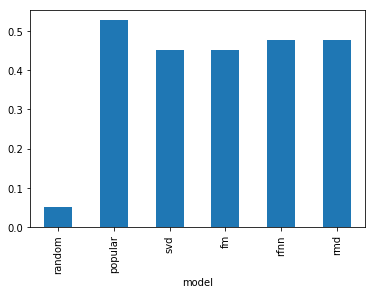

In [6]:
plot_bar(a='total_mean', b='hit_top_50_precision', c=['model'])

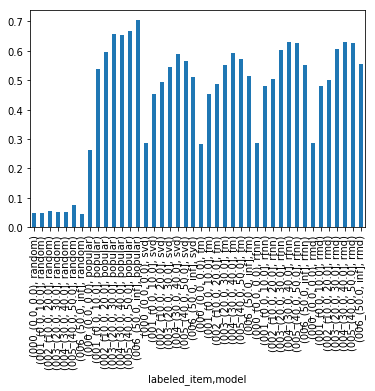

In [7]:
plot_bar(a='metrics_by_labeled_item', b='hit_top_50', c=['labeled_item', 'model'])

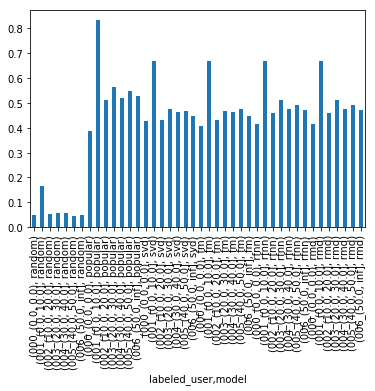

In [8]:
plot_bar(a='metrics_by_labeled_user', b='hit_top_50', c=['labeled_user', 'model'])